# Deep Learning Summarizer

In [132]:
import numpy as np
import pandas as pd
import tensorflow as tf
import opendatasets as od
from attention import AttentionLayer
import re
import contractions
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import tensorflow.keras.backend as K
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

RuntimeError: Compiled extensions are unavailable. If you've installed from a package, ask the package maintainer to include compiled extensions. If you're building Gensim from source yourself, install Cython and a C compiler, and then run `python setup.py build_ext --inplace` to retry. 

In [70]:
od.download('https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail', data_dir='./data/')

Skipping, found downloaded files in "./data/newspaper-text-summarization-cnn-dailymail" (use force=True to force download)


In [72]:
np.random.seed(128)
total_rows = 287113
skip_size = int(total_rows * 0.7)
skip_sample = np.random.choice(range(1, total_rows+1), size=skip_size, replace=False).tolist()

In [91]:
# train_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv', skiprows=skip_sample)
train_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
validation_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')
test_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(287113, 3)
(13368, 3)
(11490, 3)


In [92]:
df = pd.concat([train_df, validation_df, test_df], keys=['train', 'validation', 'test'], ignore_index=False)

In [93]:
df['article'].head(10)

train  0    By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundr...
       1    (CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, author...
       2    A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he r...
       3    (CNN) -- With a breezy sweep of his pen President Vladimir Putin wrote a new chapter into Crimea's turbulent history, committing the region to a future returned to Russian domain. Sixty years prio...
       4    Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top o

In [94]:
df['highlights'].head(10)

train  0    Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown...
       1    Criminal complaint: Cop used his role to help cocaine traffickers .\nRalph Mata, an internal affairs lieutenant, allegedly helped group get guns .\nHe also arranged to pay two assassins in a murde...
       2    Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .\nWas using phone when he veered across road in Yarmouth, Isle of Wight .\nCrashed head-on into 28-year-old Rachel Titl...
       3    Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides .\nTargeting Russia's business community would be one way of sapping their support for President Putin, she says ...
       4    Fleetwood top of League One after 2-0 win at Scunthorpe .\nPeterborough, Bristol City, Chesterfield and Crawley all drop first points of the

Things to resolve:

- Text inside parenthesis
- Text inside brackets
- Text inside curly brackets
- Words of length less than 1
- Text with symbols i.e. @, $, etc. (In general all I want is english alphabet characters and possibly numbers)
- URLs i.e. www.comsol.com
- Contractions
- Stop Words
- Lower Case
- New lines (\n) and possibly tabs (\t)


In [8]:
def clean_text(text, summary=False):
    new_text = text.lower()
    new_text = re.sub(r'\([^)]*\)|\[[^\]]*\]|\{[^}]*\}', '', new_text) # Removes text inside (), [], {}
    new_text = re.sub(r'\b(?:https?://)?(?:www\.)?\S+\.com\b', '', new_text) # Removes URLs
    new_text = re.sub(r'[\n\t]', '', new_text) # New lines and tabs
    new_text = ' '.join([contractions.fix(w) for w in new_text.split(' ')]) # Fixes contractions
    new_text = re.sub(r'[^\w\s]', ' ', new_text) # Remove non-words
    new_text = re.sub(r'\b\w*[^\w\s]+\w*\b', '', new_text) # Remove symbols from words
    new_text = re.sub(r'[^a-zA-z]', ' ', new_text) # Keeps all English alphabet characters
    stop_words = set(stopwords.words('english'))
    if not summary:
        new_text = [w for w in new_text.split() if not w in stop_words] # Removing stop words from non abstract text
    else:
        new_text = new_text.split()
    new_text = [w for w in new_text if len(w) > 1] # Removing remaining words with only 1 character
    return (' '.join(new_text)).strip() 

In [95]:
df['cleaned_article'] = df['article'].apply(lambda x: clean_text(x))

In [97]:
df['cleaned_article'].head(10)

train  0    associated press published est october updated est october bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late s...
       1    ralph mata internal affairs lieutenant miami dade police department working division investigates allegations wrongdoing cops outside office authorities allege year old longtime officer worked dru...
       2    drunk driver killed young woman head crash checking mobile phone jailed six years craig eccleston todd driving home night pub received text message reading replying veered across road driving roun...
       3    breezy sweep pen president vladimir putin wrote new chapter crimea turbulent history committing region future returned russian domain sixty years prior ukraine breakaway peninsula signed away swif...
       4    fleetwood team still record sky bet league one win scunthorpe sent graham alexander men top table cod army playing third tier first time his

In [98]:
df['cleaned_highlights'] = df['highlights'].apply(lambda x: f'<SOS> {clean_text(x, summary=True)} <EOS>')

In [99]:
df['cleaned_highlights'].head(10)

train  0    <SOS> bishop john folda of north dakota is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo grand forks and jamestown co...
       1    <SOS> criminal complaint cop used his role to help cocaine traffickers ralph mata an internal affairs lieutenant allegedly helped group get guns he also arranged to pay two assassins in murder plo...
       2    <SOS> craig eccleston todd had drunk at least three pints before driving car was using phone when he veered across road in yarmouth isle of wight crashed head on into year old rachel titley car wh...
       3    <SOS> nina dos santos says europe must be ready to accept sanctions will hurt both sides targeting russia business community would be one way of sapping their support for president putin she says ...
       4    <SOS> fleetwood top of league one after win at scunthorpe peterborough bristol city chesterfield and crawley all drop first points of the se

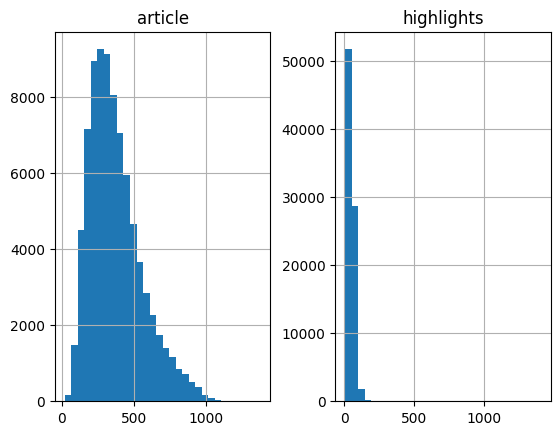

In [13]:
import matplotlib.pyplot as plt

article_word_count = []
highlights_word_count = []

for document in df['cleaned_article']:
    article_word_count.append(len(document.split(' ')))
    
for document in df['cleaned_highlights']:
    highlights_word_count.append(len(document.split(' ')))
    
count_df = pd.DataFrame({'article': article_word_count, 'highlights': highlights_word_count})
count_df.hist(bins=30)
plt.show()

In [14]:
print(f"Mean Article Word Count: {np.mean(article_word_count)}")
print(f"Median Article Word Count: {np.median(article_word_count)}")
print(f"Mean Highlights Word Count: {np.mean(highlights_word_count)}")
print(f"Median Highlights Word Count: {np.median(highlights_word_count)}")

Mean Article Word Count: 374.9631263596699
Median Article Word Count: 341.0
Mean Highlights Word Count: 49.96654148588374
Median Highlights Word Count: 47.0


In [15]:
train_df_cleaned, validation_df_cleaned, test_df_cleaned = df.xs('train'), df.xs('validation'), df.xs('test')

print(train_df_cleaned.shape[0])
print(validation_df_cleaned.shape[0])
print(test_df_cleaned.shape[0])

57423
13368
11490


In [81]:
max_article_len = 350
max_highlights_len = 48

In [104]:
def common_words_tokenizer(tokenizer, training_data, threshold=15):
    total_count = len(tokenizer.word_counts.items())
    rare_count = sum(int(i) < threshold for i in tokenizer.word_counts.values())
    new_tokenizer = Tokenizer(num_words=(total_count-rare_count))
    new_tokenizer.fit_on_texts(list(training_data))
    return new_tokenizer
    
def sequence_pad(tokenizer, data, maxlen):
    seq = tokenizer.texts_to_sequences(list(data))
    pad = pad_sequences(seq, maxlen=maxlen, padding='post')
    return pad

In [105]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_article']))
X_tokenizer = common_words_tokenizer(X_tokenizer, train_df_cleaned['cleaned_article'])
X_train = sequence_pad(X_tokenizer, train_df_cleaned['cleaned_article'], max_article_len)

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_highlights']))
y_tokenizer = common_words_tokenizer(y_tokenizer, train_df_cleaned['cleaned_highlights'])
y_train = sequence_pad(y_tokenizer, train_df_cleaned['cleaned_highlights'], max_highlights_len)

In [ ]:
with open("../models/X_tokenizer.pickle", "wb") as handle:
    pickle.dump(X_tokenizer, handle)
    
with open("../models/y_tokenizer.pickle", "wb") as handle:
    pickle.dump(y_tokenizer, handle)

In [106]:
X_vocab = X_tokenizer.num_words + 1
y_vocab = y_tokenizer.num_words + 1

print(X_vocab)
print(y_vocab)

46896
12602


In [ ]:
i

In [107]:
K.clear_session()

embed_dim = 300
latent_dim = 200

# Encoder
encoder_input = Input(shape=(max_article_len, ))
encoder_embed = Embedding(X_vocab, embed_dim, trainable=True)(encoder_input)
encoder_bidirectional = Bidirectional(LSTM(100, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_output_bi, forward_h, backward_h, forward_c, backward_c = encoder_bidirectional(encoder_embed)
state_h = Concatenate(axis=-1)([forward_h, backward_h])
state_c = Concatenate(axis=-1)([forward_c, backward_c])
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_output_bi, initial_state=[state_h, state_c])
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# Decoder
decoder_input = Input(shape=(None, ))
decoder_embed = Embedding(y_vocab, embed_dim, trainable=True)(decoder_input)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
decoder_output, _, _ = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

# Attention
attention = AttentionLayer()
attention_output, _ = attention([encoder_output3, decoder_output])

# Concatenate Attention with LSTM Output
concatenate = Concatenate(axis=-1)([decoder_output, attention_output])
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_output = decoder_dense(concatenate)

model = Model([encoder_input, decoder_input], decoder_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 350, 300)  │ 14,068,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 350,      │    320,800 │ embedding[0][0]   │
│ (Bidirectional)     │ 200), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 200)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 350,      │    320,800 │ bidirectional[0]… │
│                     │ 200), (None,      │            │ concatenate[0][0… │
│                     │ 200), (None,      │            │ concatenate_1[0]… │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 350,      │    320,800 │ lstm_1[0][0]      │
│                     │ 200), (None,      │            │                   │
│                     │ 200), (None,      │            │                   │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │  3,780,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 350,      │    320,800 │ lstm_2[0][0]      │
│                     │ 200), (None,      │            │                   │
│                     │ 200), (None,      │            │                   │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │    400,800 │ embedding_1[0][0… │
│                     │ 200), (None,      │            │ lstm_3[0][1],     │
│                     │ 200), (None,      │            │ lstm_3[0][2]      │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │     80,200 │ lstm_3[0][0],     │
│ (AttentionLayer)    │ 200), (None,      │            │ lstm_4[0][0]      │
│                     │ None, 350)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,667,002 (94.10 MB)

 Trainable params: 24,667,002 (94.10 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [109]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [110]:
X_val = sequence_pad(X_tokenizer, validation_df_cleaned['cleaned_article'], max_article_len)
y_val = sequence_pad(y_tokenizer, validation_df_cleaned['cleaned_highlights'], max_highlights_len)

In [24]:
def prep_keras_input(X, y):
    return [X, y[:, :-1]], y.reshape(y.shape[0], y.shape[1], 1)[:, 1:]

In [111]:
X_train_k, y_train_k = prep_keras_input(X_train, y_train)
X_val_k, y_val_k = prep_keras_input(X_val, y_val)

In [112]:
history = model.fit(X_train_k, y_train_k, batch_size=32, epochs=50, validation_data=(X_val_k, y_val_k), callbacks=[early_stop], verbose=1)

Epoch 1/10
   2/1795 ━━━━━━━━━━━━━━━━━━━━ 3:10:02 6s/step - loss: 9.4394  

KeyboardInterrupt: 

In [90]:
# model.save('../models/model.h5')
# model.save_weights('../models/model.weights.h5')

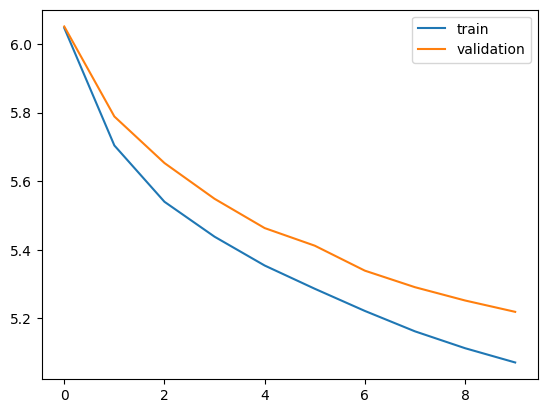

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [31]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [37]:
# encoder_model = Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])
# encoder_model.save('../models/encoder_model.h5')

In [52]:
decoder_input_state_h = Input(shape=(latent_dim, ))
decoder_input_state_c = Input(shape=(latent_dim, ))
decoder_input_hidden = Input(shape=(max_article_len, latent_dim))
decoder_embed_pred = decoder_embed
decoder_output_pred, state_h_pred, state_c_pred = decoder_lstm(decoder_embed_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])
attention_out_pred, attention_state_pred = attention([decoder_input_hidden, decoder_output_pred])
decoder_concat = Concatenate(axis=-1)([decoder_output_pred, attention_out_pred])
decoder_output_end = decoder_dense(decoder_concat)
decoder_model = Model([decoder_input] + [decoder_input_hidden, decoder_input_state_h, decoder_input_state_c], [decoder_output_end] + [state_h_pred, state_c_pred])
# decoder_model.save('../models/decoder_model.h5')

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 90)  │  1,454,310 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │    144,600 │ embedding_1[0][0… │
│                     │ 150), (None,      │            │ input_layer_17[0… │
│                     │ 150), (None,      │            │ input_layer_18[0… │
│                     │ 150)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 350, 150)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │     45,150 │ input_layer_19[0… │
│ (AttentionLayer)    │ 150), (None,      │            │ lstm_4[5][0]      │
│                     │ None, 350)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, None, 300) │          0 │ lstm_4[5][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  4,863,859 │ concatenate_7[0]… │
│ (TimeDistributed)   │ 16159)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,507,919 (24.83 MB)

 Trainable params: 6,507,919 (24.83 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
def sequence_decoder(input_seq):
    encode_out, encode_h, encode_c = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1))
    
    target_seq[0, 0] = target_word_index['sos']
    
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encode_out, encode_h, encode_c], verbose=0)
        
        sample_token_idx = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sample_token_idx]
        
        if sampled_token != 'eos':
            decoded_sentence += ' ' + sampled_token
        
        if sampled_token == 'eos' or len(decoded_sentence.split()) >= max_highlights_len - 1:
            stop_condition = True
            
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sample_token_idx
        
        encode_h, encode_c = h, c
    print(decoded_sentence)
    return decoded_sentence

In [63]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sos'] and i \
            != target_word_index['eos']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [69]:
for i in range(1000, 1010):
    print('Review:', seq2text(X_train[i]))
    print('Original summary:', seq2summary(y_train[i]))
    print('Predicted summary:', sequence_decoder(X_train[i].reshape(1,
           max_article_len)))
    print('\n')

Review: experimental drug could help millions women across world combat cellulite experimental drug could help combat dreaded cellulite plagues millions women across world new research revealed trial carried pharmaceuticals shown significant improvement appearance orange peel skin thighs buttocks women taking part cellulite term describe lumpy flesh thighs buttocks abdomen common adolescent adult women new study could provide ray hope women left feeling self conscious condition serious unsightly currently treatments cellulite approved food drug administration study involved women ages participant received three treatment sessions drug placebo treatment sessions around days apart injections administered skin buttock thigh findings revealed per cent women receiving high mid dosage drug reported satisfied satisfied cellulite treatment compared per cent patients given placebo cellulite localised metabolic disorder tissue skin affects per cent women ethnicities condition involve loss elasti